<div>
    <img src="../images/emlyon.png" style="height:60px; float:left; padding-right:10px; margin-top:5px" />
    <span>
        <h1 style="padding-bottom:5px;"> Introduction to Deep Learning </h1>
        <a href="https://masters.em-lyon.com/fr/msc-in-data-science-artificial-intelligence-strategy">[DSAIS]</a> MSc in Data Science & Artificial Intelligence Strategy <br/>
         Paris | © Saeed VARASTEH
    </span>
</div>

## Lecture 05 : Model Training: Multi-class Classification

In this notebook, we're going to work through a multi-class classification problem with PyTorch.

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

np.random.seed(72)
torch.manual_seed(72)
device = 'cpu'

let's put all you have learned together to solve a multi-class classification problem.

---

### Data

To begin a multi-class classification problem, let's create some multi-class data.

To do so, we can leverage Scikit-Learn's `make_blobs()` method.

In [2]:
from sklearn.datasets import make_blobs

# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_blobs(n_samples=1000,n_features=2,centers=4, cluster_std=1.5, random_state=42)
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
np.unique(y)

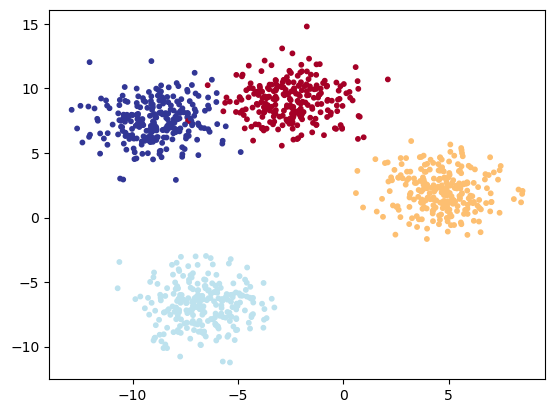

In [3]:
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, s=10, cmap=plt.cm.RdYlBu);

### Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

X_train.shape, X_test.shape, y_train.shape, y_test.shape

Nice! Looks like we've now got 800 training samples and 200 testing samples.

### Dataset

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.from_numpy(data).float()
        self.labels = torch.from_numpy(labels).long()
        
    def __getitem__(self, index):
        return (self.data[index], self.labels[index])

    def __len__(self):
        return len(self.data)
    
train_dataset = MyDataset(X_train, y_train)

<div class="alert-warning">
    <b>Note the lables types.</b>
</div>

### Train/Validation Split

In [ ]:
train_dataset, val_dataset = random_split(train_dataset, [600, 200])

len(train_dataset), len(val_dataset)

### DataLoaders

In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=32)
val_loader = DataLoader(dataset=val_dataset, batch_size=32)

### Building a Model

How about we build one similar to the last model we have created and see if is capable of handling multi-class data?

In [ ]:
class BlobsModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(),
            nn.Linear(5, 4)
            )
        
    def forward(self, x):
        out = self.fc(x)
        return out 

<div class="alert-warning">
    <b>Note</b>: output_features - the ideal numbers of output features we'd like - this will be equivalent to the number of classes in your multi-class classification problem.
</div>

Do you remember what the raw outputs of our model are called? If you guessed logits, you'd be correct.

So right now our model is outputing logits but what if we wanted to figure out exactly which label is was giving the sample?

As in, how do we go from logits -> prediction probabilities -> prediction labels just like we did with the binary classification problem?

That's where the __softmax activation function__ comes into play.

<div class="alert-info">
The softmax function calculates the probability of each prediction class being the actual predicted class compared to all other possible classes.
</div>

Since there's one value for each class after applying softmax on logits, the index of the highest value is the class the model thinks the specific data sample most belongs to.

We can check which index has the highest value using `torch.argmax()`.

Let's bring our accuracy funtion as well:

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

### Loss Function

Since we're working on a multi-class classification problem, we'll use the `nn.CrossEntropyLoss()` method as our loss function.

In [ ]:
loss_fn = nn.CrossEntropyLoss()

### Model Training 

In [ ]:
model = BlobsModel().to(device)

train_losses = []; train_accs = []
validation_losses = []; validation_accs = []

lr = 1e-1
n_epochs = 100

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # Training Loop
    model.train()
    train_loss, train_acc = 0, 0
    
    for x_batch, y_batch in train_loader: 
            
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        y_logits = model(x_batch)
        loss = loss_fn(y_logits, y_batch)
        
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()
        
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # turn logits -> pred probs -> pred labels
        train_acc += accuracy_fn(y_true=y_batch, y_pred=y_pred) 
        
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    train_acc /= len(train_loader)
    train_accs.append(train_acc)
    
    # Validation Loop
    model.eval()
    validation_loss , validation_acc = 0, 0
    
    with torch.no_grad():
        for x_val, y_val in val_loader:

            x_val = x_val.to(device)
            y_val = y_val.to(device)

            y_logits = model(x_val)
            val_loss = loss_fn(y_logits, y_val)
            
            validation_loss += val_loss.item()
            
            y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
            validation_acc += accuracy_fn(y_true=y_val, y_pred=y_pred) 
        
    validation_loss /= len(val_loader)
    validation_losses.append(validation_loss)
    
    validation_acc /= len(val_loader)
    validation_accs.append(validation_acc)
    
    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_acc:.2f}% | val loss: {validation_loss:.5f}, val acc: {validation_acc:.2f}%")


Learning curves:

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(train_losses,  label="train loss"); 
ax[0].plot(validation_losses,  label="val loss"); 
ax[0].legend();

ax[1].plot(train_accs,  label="train acc");
ax[1].plot(validation_accs,  label="val acc"); 
ax[1].legend();

### Making Predications

In [ ]:
y_pred = model( torch.from_numpy(X_train).float().to(device) )
y_pred = torch.softmax(y_pred, dim=1).argmax(dim=1).detach().numpy()

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(X_train[:,0], X_train[:,1], c=y_train, label="actual data");
ax[0].legend();

ax[1].scatter(X_train[:,0], X_train[:,1], c=y_pred, label="predicted data");
ax[1].legend();

plt.legend()

---